# Import Libs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, classification_report

# Data Loading

## Features

In [2]:
feature = pd.read_csv('feature.csv')
feature

,client_id,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,...,private_label_purchase_ratio,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months
0,000012768d,45.0,U,152,2017,8,5,2018,1,4,...,0.750000,4,40809.00,4,40809.00,4,40809.00,4,40809.00,-39.631391
1,000036f903,72.0,F,13,2017,4,10,2017,4,23,...,0.375000,26,57230.00,23,55149.00,21,53261.00,11,40187.00,418.904687
2,000048b7a6,68.0,F,180,2018,12,15,2019,6,13,...,0.250000,8,29724.00,6,28475.00,6,28475.00,4,24917.00,542.172285
3,000073194a,60.0,F,185,2017,5,23,2017,11,24,...,0.176471,13,61370.92,12,60728.62,8,57335.49,7,55394.49,2126.855328
4,00007c7133,67.0,U,588,2017,5,22,2018,12,31,...,0.727273,10,53658.72,10,53658.72,10,53658.72,9,52033.72,262.436585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400157,fffece623e,67.0,U,228,2018,5,13,2018,12,27,...,0.500000,16,40978.89,13,39216.89,11,37469.89,7,32418.69,25.273913
400158,ffff3dfff8,56.0,F,36,2018,11,1,2018,12,7,...,0.470588,14,65354.56,12,64236.56,10,62558.36,7,58846.45,-38.400876
400159,ffffaab9da,23.0,F,105,2017,8,25,2017,12,8,...,0.571429,6,40650.00,6,40650.00,5,39894.00,4,38394.00,0.000000
400160,ffffeb5619,62.0,U,180,2017,12,5,2018,6,3,...,0.428571,6,279053.68,6,279053.68,6,279053.68,6,279053.68,0.000000


## Train Data

In [3]:
uplift_train = pd.read_csv('data/uplift_train.csv') 
uplift_train

,client_id,treatment_flg,target
0,000012768d,0,1
1,000036f903,1,1
2,00010925a5,1,1
3,0001f552b0,1,1
4,00020e7b18,1,1
...,...,...,...
200034,fffe0abb97,0,0
200035,fffe0ed719,0,1
200036,fffea1204c,0,1
200037,fffeca6d22,1,0


## Train dataset creating

In [4]:
train = uplift_train.merge(feature, on = 'client_id', how = 'left')
train = train.set_index('client_id')
train

,treatment_flg,target,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,...,private_label_purchase_ratio,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,0,1,45.0,U,152,2017,8,5,2018,1,...,0.750000,4,40809.00,4,40809.00,4,40809.00,4,40809.00,-39.631391
000036f903,1,1,72.0,F,13,2017,4,10,2017,4,...,0.375000,26,57230.00,23,55149.00,21,53261.00,11,40187.00,418.904687
00010925a5,1,1,83.0,U,52,2018,7,24,2018,9,...,0.388889,13,26283.00,11,25182.00,9,23276.00,8,21761.00,95.305213
0001f552b0,1,1,33.0,F,424,2017,6,30,2018,8,...,0.466667,11,47085.83,11,47085.83,10,46257.99,8,43126.26,118.382838
00020e7b18,1,1,73.0,U,44,2017,11,27,2018,1,...,0.833333,17,558881.46,17,558881.46,16,558014.55,16,558014.55,145.234545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe0abb97,0,0,35.0,F,76,2017,11,27,2018,2,...,0.111111,4,18720.23,4,18720.23,3,17913.92,3,17913.92,64.182615
fffe0ed719,0,1,69.0,U,88,2017,9,15,2017,12,...,0.733333,23,74902.47,19,72185.47,19,72185.47,15,67417.82,1878.334777
fffea1204c,0,1,73.0,F,40,2018,1,31,2018,3,...,0.000000,9,18061.91,7,16827.17,6,15887.37,5,14752.29,467.564253


## Test Data

In [5]:
uplift_test = pd.read_csv('data/uplift_test.csv')
uplift_test

,client_id
0,000048b7a6
1,000073194a
2,00007c7133
3,00007f9014
4,0000a90cf7
...,...
200118,fffeacbe3e
200119,fffece623e
200120,ffff3dfff8
200121,ffffaab9da


## Test dataset creating

In [6]:
test = uplift_test.merge(feature, on = 'client_id', how = 'left')
test = test.set_index('client_id')
test

,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,total_purchase_sum,...,private_label_purchase_ratio,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months
client_id,,,,,,,,,,,,,,,,,,,,,
000048b7a6,68.0,F,180,2018,12,15,2019,6,13,29724.00,...,0.250000,8,29724.00,6,28475.00,6,28475.00,4,24917.00,542.172285
000073194a,60.0,F,185,2017,5,23,2017,11,24,62719.92,...,0.176471,13,61370.92,12,60728.62,8,57335.49,7,55394.49,2126.855328
00007c7133,67.0,U,588,2017,5,22,2018,12,31,53998.72,...,0.727273,10,53658.72,10,53658.72,10,53658.72,9,52033.72,262.436585
00007f9014,45.0,F,542,2017,8,22,2019,2,15,39557.35,...,0.137931,18,37077.79,16,35812.13,14,34087.25,6,23599.51,110.490429
0000a90cf7,45.0,U,49,2017,5,20,2017,7,8,133328.28,...,0.514286,30,131647.80,25,128350.64,21,124926.53,12,112005.53,85.163683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffeacbe3e,47.0,F,86,2017,7,19,2017,10,13,47581.35,...,0.916667,9,46314.59,9,46314.59,8,45314.59,6,42754.81,120.542643
fffece623e,67.0,U,228,2018,5,13,2018,12,27,43103.46,...,0.500000,16,40978.89,13,39216.89,11,37469.89,7,32418.69,25.273913
ffff3dfff8,56.0,F,36,2018,11,1,2018,12,7,65810.71,...,0.470588,14,65354.56,12,64236.56,10,62558.36,7,58846.45,-38.400876


# 1) Treatment Dummy approach - cамое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомый uplift

<img src="Treatment Dummy approach.png"  width="1000"/>

## Деление на таргет и фичи, treatment_flag - тоже фича

In [7]:
target = 'target'
features = [col for col in train.columns if col not in target]

## Отделение категориальных фичей

In [8]:
cat_features = [col for col in train.columns if train[col].dtype == 'object' and col not in target]

## Трейн для Treatment Dummy approach 

In [9]:
train_tda = train.copy()

In [10]:
X_tda = train_tda[features]
y_tda = train_tda[target]

## Train Test split

In [11]:
X_train_tda, X_test_tda, y_train_tda, y_test_tda = train_test_split(X_tda, y_tda, test_size=0.2, random_state=42)

## Model

In [12]:
model_tda = CatBoostClassifier(
    iterations = 2000,  
    learning_rate=0.01, 
    depth=3, 
    bootstrap_type='Bernoulli', 
    subsample=0.8,
    cat_features = cat_features,
    logging_level='Verbose',
    metric_period = 250,
    random_seed = 42,
    custom_loss = ['AUC']
)
model_tda.fit(
    X_train_tda, y_train_tda,
    cat_features=cat_features,
    eval_set=(X_test_tda, y_test_tda),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5393883381
bestIteration = 1999



## Feature Importances

In [13]:
feature_importances = model_tda.get_feature_importance()
feature_names = X_train_tda.columns  # Если X_train_tda — DataFrame

# Создаем DataFrame для наглядности
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

## Vizualization feature importances

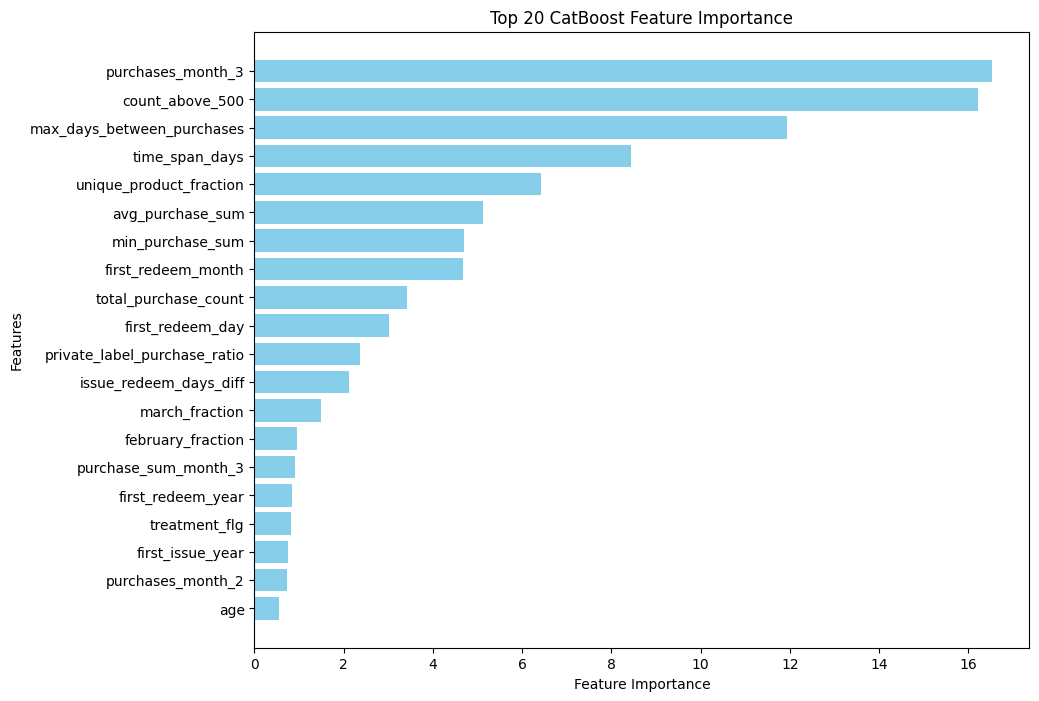

In [14]:
top_20_features = feature_importance_df.head(20)
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 CatBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## Model Quality

In [15]:
y_pred_tda = model_tda.predict(X_test_tda)

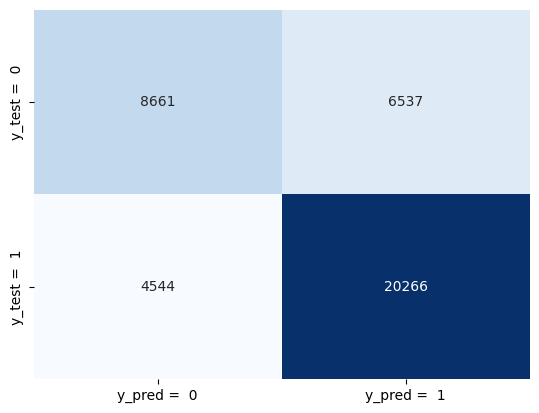

In [16]:
matrix_treatment = confusion_matrix(y_test_tda, y_pred_tda)
sns.heatmap(matrix_treatment, annot=True, fmt='g', cbar=None, cmap="Blues", 
            xticklabels=['y_pred =  0', 'y_pred =  1'], yticklabels=['y_test =  0', 'y_test =  1']);

## Quality metrics

In [17]:
accuracy_tda = accuracy_score(y_test_tda, y_pred_tda)
precision_tda = precision_score(y_test_tda, y_pred_tda)
recall_tda= recall_score(y_test_tda, y_pred_tda)
roc_auc_tda = roc_auc_score(y_test_tda, y_pred_tda)
f1_tda = f1_score(y_test_tda, y_pred_tda)
print(f'Accuracy: {accuracy_tda:.4f}')
print(f'Precision: {precision_tda:.4f}')
print(f'Recall: {recall_tda:.4f}')
print(f'ROC AUC: {roc_auc_tda:.4f}')
print(f'F1 Score: {f1_tda:.4f}')

Accuracy: 0.7230
Precision: 0.7561
Recall: 0.8168
ROC AUC: 0.6934
F1 Score: 0.7853


## Predictions

In [18]:
test

,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,total_purchase_sum,...,private_label_purchase_ratio,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months
client_id,,,,,,,,,,,,,,,,,,,,,
000048b7a6,68.0,F,180,2018,12,15,2019,6,13,29724.00,...,0.250000,8,29724.00,6,28475.00,6,28475.00,4,24917.00,542.172285
000073194a,60.0,F,185,2017,5,23,2017,11,24,62719.92,...,0.176471,13,61370.92,12,60728.62,8,57335.49,7,55394.49,2126.855328
00007c7133,67.0,U,588,2017,5,22,2018,12,31,53998.72,...,0.727273,10,53658.72,10,53658.72,10,53658.72,9,52033.72,262.436585
00007f9014,45.0,F,542,2017,8,22,2019,2,15,39557.35,...,0.137931,18,37077.79,16,35812.13,14,34087.25,6,23599.51,110.490429
0000a90cf7,45.0,U,49,2017,5,20,2017,7,8,133328.28,...,0.514286,30,131647.80,25,128350.64,21,124926.53,12,112005.53,85.163683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffeacbe3e,47.0,F,86,2017,7,19,2017,10,13,47581.35,...,0.916667,9,46314.59,9,46314.59,8,45314.59,6,42754.81,120.542643
fffece623e,67.0,U,228,2018,5,13,2018,12,27,43103.46,...,0.500000,16,40978.89,13,39216.89,11,37469.89,7,32418.69,25.273913
ffff3dfff8,56.0,F,36,2018,11,1,2018,12,7,65810.71,...,0.470588,14,65354.56,12,64236.56,10,62558.36,7,58846.45,-38.400876


In [19]:
test_treatment = test.copy()
test_control = test.copy()

## Оцениваем модель, используя фичу treatment_flg - сначала 0, потом 1

In [20]:
test_treatment['treatment_flg'] = 1
test_control['treatment_flg'] = 0

## Достаем уверенность модели в присвоении определенного класса

In [21]:
test_treatment['pred_treatment'] = model_tda.predict_proba(test_treatment[features])[:, 1]
test_control['pred_control'] = model_tda.predict_proba(test_control[features])[:, 1]

In [22]:
test_tda = test.copy()

## Считаем аплифт

In [23]:
test_tda['pred_treatment'] = test_treatment['pred_treatment']
test_tda['pred_control'] = test_control['pred_control']
test_tda['uplift'] = test_tda['pred_treatment'] - test_tda['pred_control']

In [24]:
test_tda.sort_values(by='uplift', ascending=False)

,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,total_purchase_sum,...,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months,pred_treatment,pred_control,uplift
client_id,,,,,,,,,,,,,,,,,,,,,
e96879ea1b,67.0,M,22,2019,3,8,2019,3,30,23.00,...,0,0.00,0,0.00,0,0.00,0.000000,0.567481,0.490663,0.076818
8f69df0aca,61.0,U,14,2019,3,10,2019,3,24,304.46,...,0,0.00,0,0.00,0,0.00,0.000000,0.561183,0.485685,0.075498
bacf846b06,56.0,U,19,2019,3,11,2019,3,30,26.40,...,0,0.00,0,0.00,0,0.00,0.000000,0.558442,0.483286,0.075155
b091194c8f,62.0,M,13,2019,3,9,2019,3,22,148.00,...,0,0.00,0,0.00,0,0.00,0.000000,0.591799,0.516734,0.075065
3beb3e1e59,61.0,U,60,2019,1,29,2019,3,30,891.00,...,1,807.00,0,0.00,0,0.00,0.000000,0.543548,0.469264,0.074285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671f816e02,60.0,U,169,2017,6,7,2017,11,23,157068.80,...,63,142361.50,51,132158.36,28,98129.21,353.442862,0.985721,0.984175,0.001546
e1a4f70d31,38.0,U,146,2017,8,13,2018,1,6,136622.47,...,55,119702.81,45,111076.77,16,69409.32,493.127347,0.985354,0.983829,0.001525
cc7f658c82,35.0,M,437,2017,7,3,2018,9,13,318862.41,...,110,285844.71,89,267303.76,43,202373.11,165.162537,0.982425,0.980945,0.001480


## Uplift VIZ

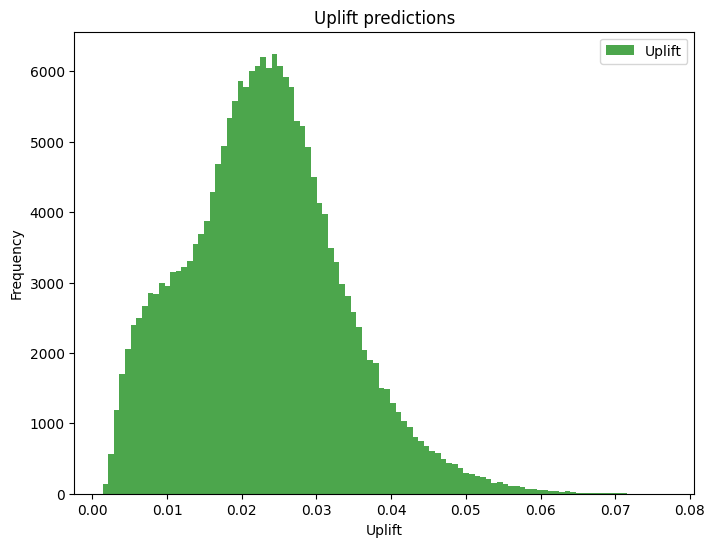

In [25]:
plt.figure(figsize=(8, 6))
plt.hist(test_tda['uplift'], bins=100, color='green', alpha=0.7, label='Uplift')  
plt.title('Uplift predictions')  
plt.xlabel('Uplift')  
plt.ylabel('Frequency') 
plt.legend() 
plt.show()

# 2) Two Models Aproach

## Подход с двумя моделями один из самых популярных и достаточно часто встречается в статьях, например [3] и [4]. Метод заключается в отдельном моделировании двух условных вероятностей на целевой и контрольной группах, а именно:

- **1)** Строится первая модель, оценивающая вероятность выполнения целевого действия среди клиентов, с которыми мы взаимодействовали.
- **2)** Строится вторая модель, оценивающая ту же вероятность, но среди клиентов, с которыми мы не производили коммуникацию.
- **3)** Затем для каждого клиента рассчитывается разность оценок вероятностей двух моделей

<img src="Two Models Aproach.png"  width="1000"/>

In [26]:
train_tma = train.copy()

In [27]:
train_tma

,treatment_flg,target,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,...,private_label_purchase_ratio,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,0,1,45.0,U,152,2017,8,5,2018,1,...,0.750000,4,40809.00,4,40809.00,4,40809.00,4,40809.00,-39.631391
000036f903,1,1,72.0,F,13,2017,4,10,2017,4,...,0.375000,26,57230.00,23,55149.00,21,53261.00,11,40187.00,418.904687
00010925a5,1,1,83.0,U,52,2018,7,24,2018,9,...,0.388889,13,26283.00,11,25182.00,9,23276.00,8,21761.00,95.305213
0001f552b0,1,1,33.0,F,424,2017,6,30,2018,8,...,0.466667,11,47085.83,11,47085.83,10,46257.99,8,43126.26,118.382838
00020e7b18,1,1,73.0,U,44,2017,11,27,2018,1,...,0.833333,17,558881.46,17,558881.46,16,558014.55,16,558014.55,145.234545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe0abb97,0,0,35.0,F,76,2017,11,27,2018,2,...,0.111111,4,18720.23,4,18720.23,3,17913.92,3,17913.92,64.182615
fffe0ed719,0,1,69.0,U,88,2017,9,15,2017,12,...,0.733333,23,74902.47,19,72185.47,19,72185.47,15,67417.82,1878.334777
fffea1204c,0,1,73.0,F,40,2018,1,31,2018,3,...,0.000000,9,18061.91,7,16827.17,6,15887.37,5,14752.29,467.564253


## treatment_flg - не фича

In [28]:
non_features = ['target' , 'treatment_flg']
features_tma = [col for col in train_tma.columns if col not in non_features]

## Категориальные фичи

In [29]:
cat_features = [col for col in train_tma.columns if train_tma[col].dtype == 'object' and col not in non_features]

In [30]:
cat_features

['gender',
 'most_frequent_product',
 'most_frequent_brand',
 'most_frequent_store']

## Делю на две выборки под каждую модель

In [31]:
treatment_group = train_tma[train_tma['treatment_flg'] == 1]
control_group = train_tma[train_tma['treatment_flg'] == 0]

In [32]:
X_treatment = treatment_group[features_tma]
y_treatment = treatment_group['target']
X_control = control_group[features_tma]
y_control = control_group['target']

In [33]:
X_train_treatment, X_test_treatment, y_train_treatment, y_test_treatment = train_test_split(X_treatment, y_treatment, test_size=0.2, random_state=42)
X_train_control, X_test_control, y_train_control, y_test_control = train_test_split(X_control, y_control, test_size=0.2, random_state=42)

## Treatment Model

In [34]:
model_treatment = CatBoostClassifier(
    iterations = 2000,  
    learning_rate=0.01, 
    depth=3, 
    bootstrap_type='Bernoulli', 
    subsample=0.8,
    cat_features = cat_features,
    logging_level='Verbose',
    metric_period = 250,
    random_seed = 42,
    custom_loss = ['AUC']
)
model_treatment.fit(
    X_train_treatment, y_train_treatment,
    cat_features=cat_features,
    eval_set=(X_test_treatment, y_test_treatment),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5324758076
bestIteration = 1999



## Control Model

In [35]:
model_control = CatBoostClassifier(
    iterations = 2000,  
    learning_rate=0.005, 
    depth=3, 
    bootstrap_type='Bernoulli', 
    subsample=0.8,
    cat_features = cat_features,
    logging_level='Verbose',
    metric_period = 250,
    random_seed = 42,
    custom_loss = ['AUC']
)
model_control.fit(
    X_train_control, y_train_control,
    cat_features=cat_features,
    eval_set=(X_test_control, y_test_control),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.554469092
bestIteration = 1999



## Predictions

In [36]:
test

,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,total_purchase_sum,...,private_label_purchase_ratio,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months
client_id,,,,,,,,,,,,,,,,,,,,,
000048b7a6,68.0,F,180,2018,12,15,2019,6,13,29724.00,...,0.250000,8,29724.00,6,28475.00,6,28475.00,4,24917.00,542.172285
000073194a,60.0,F,185,2017,5,23,2017,11,24,62719.92,...,0.176471,13,61370.92,12,60728.62,8,57335.49,7,55394.49,2126.855328
00007c7133,67.0,U,588,2017,5,22,2018,12,31,53998.72,...,0.727273,10,53658.72,10,53658.72,10,53658.72,9,52033.72,262.436585
00007f9014,45.0,F,542,2017,8,22,2019,2,15,39557.35,...,0.137931,18,37077.79,16,35812.13,14,34087.25,6,23599.51,110.490429
0000a90cf7,45.0,U,49,2017,5,20,2017,7,8,133328.28,...,0.514286,30,131647.80,25,128350.64,21,124926.53,12,112005.53,85.163683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffeacbe3e,47.0,F,86,2017,7,19,2017,10,13,47581.35,...,0.916667,9,46314.59,9,46314.59,8,45314.59,6,42754.81,120.542643
fffece623e,67.0,U,228,2018,5,13,2018,12,27,43103.46,...,0.500000,16,40978.89,13,39216.89,11,37469.89,7,32418.69,25.273913
ffff3dfff8,56.0,F,36,2018,11,1,2018,12,7,65810.71,...,0.470588,14,65354.56,12,64236.56,10,62558.36,7,58846.45,-38.400876


In [37]:
test_tma = test.copy()

## Calculate Uplift

In [38]:
test_tma['pred_treatment'] = model_treatment.predict_proba(test_tma)[:, 1]  # Вероятности для группы с воздействием
test_tma['pred_control'] = model_control.predict_proba(test_tma)[:, 1]  # Вероятности для группы без воздействия
test_tma['uplift'] = test_tma['pred_treatment'] - test_tma['pred_control']

In [39]:
test_tma.sort_values(by='uplift', ascending=False)

,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,total_purchase_sum,...,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months,pred_treatment,pred_control,uplift
client_id,,,,,,,,,,,,,,,,,,,,,
507f44bde2,63.0,M,17,2019,3,6,2019,3,23,2087.76,...,1,1995.00,1,1995.00,0,0.00,0.0,0.784483,0.312926,0.471557
9383ec9201,65.0,M,14,2019,3,8,2019,3,22,330.00,...,0,0.00,0,0.00,0,0.00,0.0,0.824284,0.354364,0.469919
99de1f552c,69.0,M,46,2019,2,5,2019,3,23,419.00,...,0,0.00,0,0.00,0,0.00,0.0,0.789002,0.321478,0.467523
112741d4ae,65.0,U,11,2019,3,11,2019,3,22,2544.00,...,1,2544.00,1,2544.00,1,2544.00,0.0,0.679421,0.212699,0.466723
d874a01779,77.0,U,15,2019,3,9,2019,3,24,1227.25,...,1,1147.36,1,1147.36,0,0.00,0.0,0.759178,0.294903,0.464275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27d178b8d4,34.0,M,180,2019,2,15,2019,8,14,13182.00,...,4,12582.00,4,12582.00,4,12582.00,0.0,0.236094,0.394691,-0.158597
0f3896bca4,28.0,U,180,2019,2,14,2019,8,13,34830.36,...,7,33006.32,6,32166.44,5,30501.59,0.0,0.330150,0.493585,-0.163435
99edaf3e34,45.0,M,180,2018,2,2,2018,8,1,90910.00,...,17,88802.00,15,87148.00,12,82784.00,0.0,0.340812,0.520154,-0.179342


## Vizualization Uplift

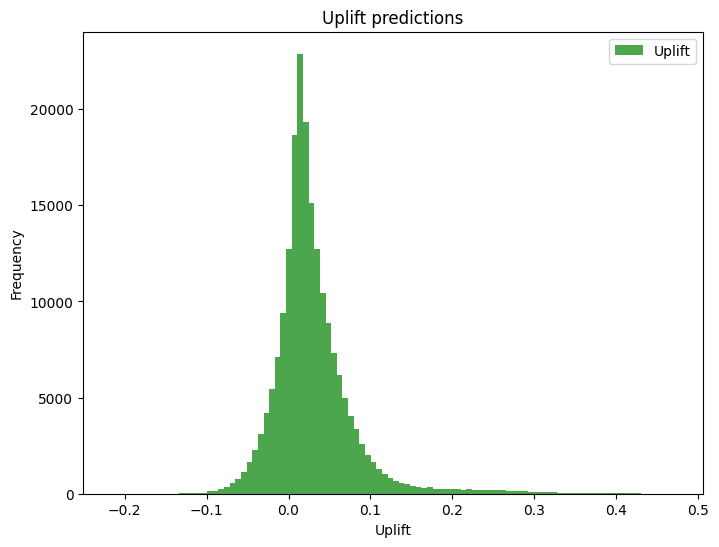

In [40]:
plt.figure(figsize=(8, 6))
plt.hist(test_tma['uplift'], bins=100, color='green', alpha=0.7, label='Uplift')  
plt.title('Uplift predictions')  
plt.xlabel('Uplift')  
plt.ylabel('Frequency') 
plt.legend() 
plt.show()

# Class Transformation Approach

# Modeling Uplift Directly